# A4-Q3: Convolutional Autoencoders

## Preliminaries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# In case you are fortunate enough to have access to a GPU...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset: MNIST

In [3]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            ]))

In [4]:
ds = torch.utils.data.Subset(ds_full, range(1024))

In [5]:
def Draw(x):
    with torch.no_grad():
        plt.imshow(x.squeeze().detach().numpy(), cmap='gray');
        plt.axis('off');

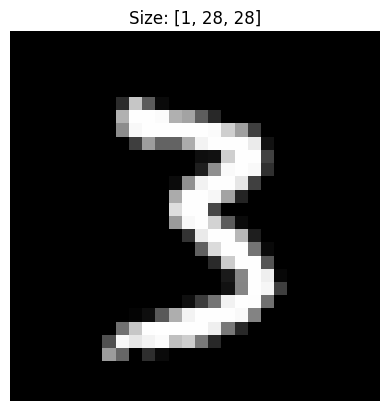

In [7]:
with torch.no_grad():
    x,t = ds.__getitem__(130)
    Draw(x)
    plt.title(f'Size: {list(x.size())}')
plt.show()

## Create some `DataLoader`s

In [8]:
# Batched, for training
batch_size_train = 8
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)

In [9]:
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)

# A. Complete the `ConvAE` class

In [26]:
class ConvAE(nn.Module):
    '''
     net = ConvAE(img_size=28, embedding_dim=3)
     
     Create a convolutional autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images, [1, img_size, img_size]
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = ConvAE()
       y = net(x)
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, img_size=28, embedding_dim=3):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        
        #===== YOUR CODE HERE =====
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.fc_enc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(True),
            nn.Linear(128, embedding_dim),
            nn.Tanh()
        )

        self.fc_dec = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (64, 4, 4))
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        #===== YOUR CODE HERE =====
        x = self.encoder(x)
        h = self.fc_enc(x)
        return h
    
    
    def decode(self, x):
        #===== YOUR CODE HERE =====
        h = self.fc_dec(x)
        x = self.decoder(h)
        x = x[:, :, :self.img_size, :self.img_size]
        return x
  

    def forward(self, x):
        #===== YOUR CODE HERE =====
        h = self.encode(x)
        y = self.decode(h)
        return y


# B. Create and train the network

In [29]:
net = ConvAE(img_size=img_size, embedding_dim=3)

In [30]:
# Train it
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs = 20

for epoch in range(epochs):
    net.train()
    running_loss = 0

    for x, _ in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
        x = x.to(device)

        y_pred = net(x)

        loss = criterion(y_pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_dl)
    net.losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}]  Average Loss: {avg_loss:.6f}")

print("\nTraining complete!")

Epoch 1/20: 100%|██████████| 128/128 [00:00<00:00, 306.76it/s]


Epoch [1/20]  Average Loss: 0.101784


Epoch 2/20: 100%|██████████| 128/128 [00:00<00:00, 327.83it/s]


Epoch [2/20]  Average Loss: 0.066434


Epoch 3/20: 100%|██████████| 128/128 [00:00<00:00, 331.09it/s]


Epoch [3/20]  Average Loss: 0.066225


Epoch 4/20: 100%|██████████| 128/128 [00:00<00:00, 312.95it/s]


Epoch [4/20]  Average Loss: 0.066140


Epoch 5/20: 100%|██████████| 128/128 [00:00<00:00, 297.68it/s]


Epoch [5/20]  Average Loss: 0.066101


Epoch 6/20: 100%|██████████| 128/128 [00:00<00:00, 329.79it/s]


Epoch [6/20]  Average Loss: 0.066189


Epoch 7/20: 100%|██████████| 128/128 [00:00<00:00, 342.96it/s]


Epoch [7/20]  Average Loss: 0.066051


Epoch 8/20: 100%|██████████| 128/128 [00:00<00:00, 309.16it/s]


Epoch [8/20]  Average Loss: 0.066136


Epoch 9/20: 100%|██████████| 128/128 [00:00<00:00, 339.83it/s]


Epoch [9/20]  Average Loss: 0.066094


Epoch 10/20: 100%|██████████| 128/128 [00:00<00:00, 329.11it/s]


Epoch [10/20]  Average Loss: 0.066052


Epoch 11/20: 100%|██████████| 128/128 [00:00<00:00, 339.20it/s]


Epoch [11/20]  Average Loss: 0.066137


Epoch 12/20: 100%|██████████| 128/128 [00:00<00:00, 337.90it/s]


Epoch [12/20]  Average Loss: 0.066085


Epoch 13/20: 100%|██████████| 128/128 [00:00<00:00, 340.72it/s]


Epoch [13/20]  Average Loss: 0.066010


Epoch 14/20: 100%|██████████| 128/128 [00:00<00:00, 333.79it/s]


Epoch [14/20]  Average Loss: 0.066038


Epoch 15/20: 100%|██████████| 128/128 [00:00<00:00, 336.09it/s]


Epoch [15/20]  Average Loss: 0.066026


Epoch 16/20: 100%|██████████| 128/128 [00:00<00:00, 337.47it/s]


Epoch [16/20]  Average Loss: 0.065996


Epoch 17/20: 100%|██████████| 128/128 [00:00<00:00, 324.03it/s]


Epoch [17/20]  Average Loss: 0.065959


Epoch 18/20: 100%|██████████| 128/128 [00:00<00:00, 319.02it/s]


Epoch [18/20]  Average Loss: 0.066025


Epoch 19/20: 100%|██████████| 128/128 [00:00<00:00, 309.23it/s]


Epoch [19/20]  Average Loss: 0.065994


Epoch 20/20: 100%|██████████| 128/128 [00:00<00:00, 336.43it/s]

Epoch [20/20]  Average Loss: 0.066014

Training complete!


In [31]:
# Uncomment the following line if you want to save your network.
#torch.save(net.to('cpu'), 'my_ConvAE.pt')
# The corresponding code to reload the network is below.
#net = torch.load('my_ConvAE.pt')
# Remember to send it to the GPU, if you're using one.
net.to(device)

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_enc): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=3, bias=True)
    (3): Tanh()
  )
  (fc_dec): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(64, 4, 4))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=Tr

# C. Plot the latent space

In [32]:
# Here are 10 colours you can use. But feel free to use others, too.
colour_options = ['k', 'tab:brown', 'r', 'orange', 'gold', 'lawngreen', 'forestgreen', 'blue', 'mediumpurple', 'gray']

In [ ]:
# Compute the latent-space representation for all the samples.


In [ ]:
# You can create three 2D planar projections.


In [ ]:
# Or you can plot a 3D scatter plot.
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(...)
#===== YOUR CODE HERE =====


# D. Plot reconstructed digit images

Digit Reconstructions

